In [1]:
%%HTML
<style>
    body
    {
        --vscode-font-family: Courier New
    }
<style>

<style>
    div
    {
        background-color: white;
        color: black;
    }
    h1
    {
        color: green;
    }
</style>
<div>
    <h1>BÀI TOÁN VỚI CƠ SỞ DỮ LIỆU MOVIELENS 100K</h1>
    Trong phần này chúng ta sẽ sử dụng thuật toán collaborative filtering trong chương này tương đối đơn giản và không chứa bài toán tối ưu nào. Chúng ta sẽ sử dụng bộ cơ sở dữ liệu MovieLens 100k như trong chương trước. 
    Trong project này chúng ta sẽ viết 1 class uuCF cho user-user collaborative filtering. Có 2 phương thức chính của class này là fit-tính ma trận similarity và predict-dự đoán số sao mà 1 user sẽ đánh giá 1 item
</div>

In [4]:
from __future__ import print_function
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity 
from scipy import sparse

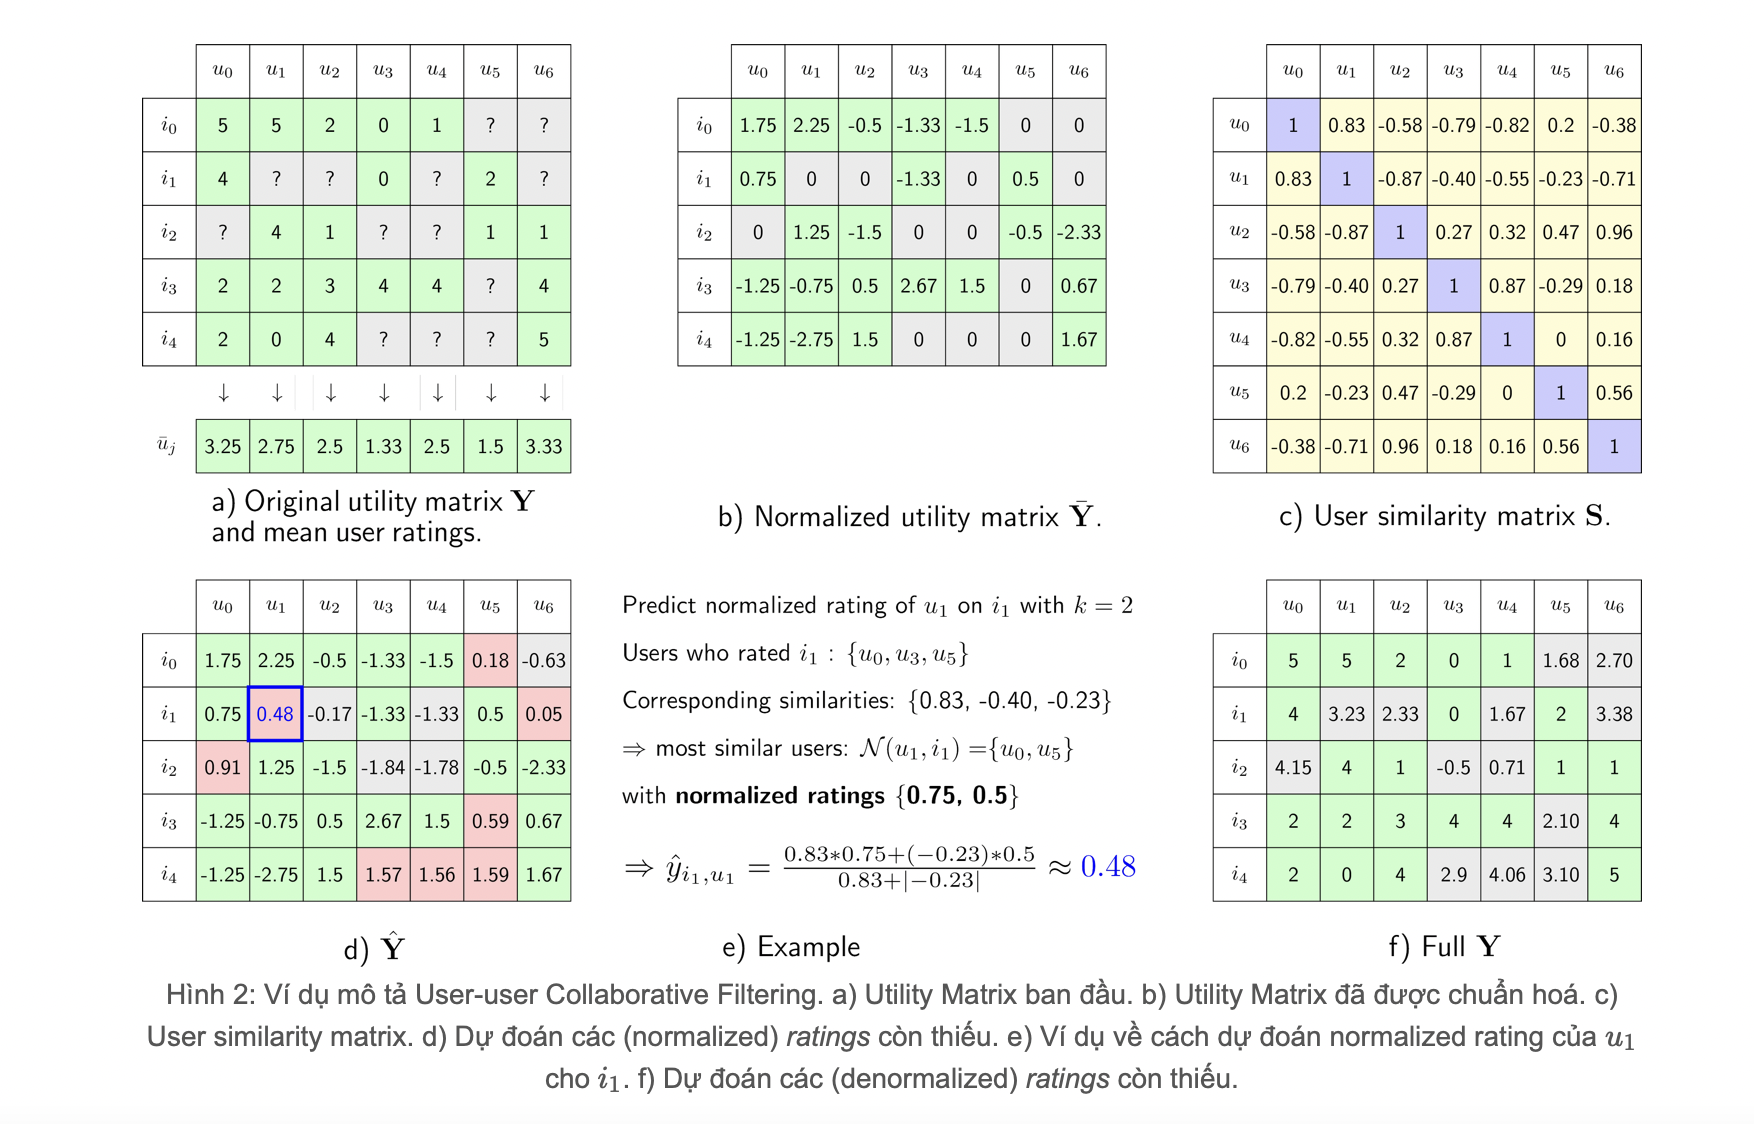

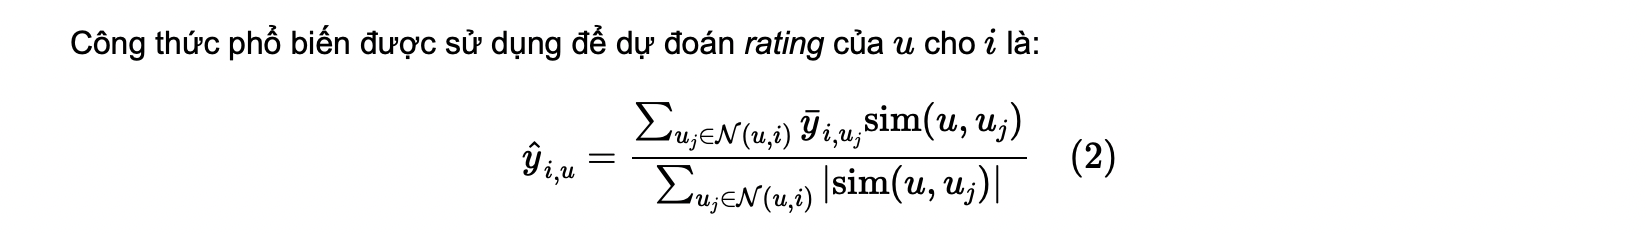

In [43]:
class uuCF(object):
    def __init__(self, Y_data,  k, sim_func = cosine_similarity):
        self.Y_data = Y_data # a 2d array of shape (n_users, 3)
                            # each row of Y_data has from [user_id, item_id, rating]
        self.k = k # number of neighbors
        self.simfunc = sim_func
        self.Ybar = None #nomalize data
        self.n_users = int(np.max(Y_data[:,0])) + 1
        self.n_items = int(np.max(Y_data[:,1])) + 1

    def fit(self):
        # nomalize Y_data -> Ybar
        users = self.Y_data[:, 0] # all user - first column of Y_data
        self.Ybar = self.Y_data.copy()
        self.mu = np.zeros((self.n_users, ))
        for n in range(self.n_users):
            # row indicates of rating made by user n
            ids = np.where(users == n)[0].astype(np.int32) # return index of column where userid = n
            # indicase of all items rated by user n
            items_ids = self.Y_data[ids, 1]
            # rating made by user n
            rating = self.Y_data[ids, 2]
            # avoid zeros division
            self.mu[n] = np.mean(rating)
            self.Ybar[ids, 2] = rating - self.mu[n]

        #from the rating matrix as a sparse matrix
        self.Ybar = sparse.coo_matrix((self.Ybar[:, 2], (self.Ybar[:, 1], self.Ybar[:, 0])), shape=(self.n_items, self.n_users)).tocsr()
        self.S = self.simfunc(self.Ybar.T, self.Ybar.T)

    def pred(self, u, i):
        """predict the items rating of user u for item i"""
        # find item i
        ids = np.where(self.Y_data[:, 1])[0].astype(np.int32)
        # all user who rated i
        users_rated_i = (self.Y_data[ids, 0]).astype(np.int32)
        sim = self.S[u, users_rated_i]
        # argsort retrun index of matrix after sorted
        # take k users similar with u
        nns = np.argsort(sim)[-self.k:]
        nearest_s = sim[nns]
        # the corresponding ratings
        r = self.Ybar[i, users_rated_i[nns]]
        eps = 1e-8
        return (r*nearest_s).sum()/(np.abs(nearest_s).sum() + eps) + self.mu[u]    


In [44]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
rating_base = pd.read_csv('./ml-100k/ua.base', sep = '\t', names =r_cols)
rating_test = pd.read_csv('./ml-100k/ua.test', sep = '\t', names =r_cols)
rate_train = rating_base.values
rate_test = rating_test.values

rate_train[:, :2] -= 1
rate_test[:, :2] -=1

rs = uuCF(rate_train, k = 40)
rs.fit()

n_test = rate_test.shape[0]
SE = 0
for n in range(n_test):
    pred = rs.pred(rate_test[n, 0], rate_test[n, 1])
    SE += (pred - rate_test[n , 2])**2
RMSE = np.sqrt(SE/n_test)
print(RMSE)


1.0417488305373739


Chức năng của matrix_coo và hàm tocsr()

In [28]:

import numpy as np
from scipy.sparse import coo_matrix

# Tạo một ma trận thưa COO
row = np.array([0, 1, 1, 2, 3])
col = np.array([1, 0, 2, 2, 3])
data = np.array([3, 4, 5, 6, 7])
sparse_matrix_coo = coo_matrix((data, (row, col)), shape=(4, 4))

# Chuyển đổi ma trận thưa COO sang CSR
sparse_matrix_csr = sparse_matrix_coo.tocsr()
# In ma trận thưa COO
print("Ma trận thưa COO:")
print(sparse_matrix_coo)
# In ma trận thưa CSR
print("Ma trận thưa CSR:")
print(sparse_matrix_csr)


Ma trận thưa COO:
  (0, 1)	3
  (1, 0)	4
  (1, 2)	5
  (2, 2)	6
  (3, 3)	7
Ma trận thưa CSR:
  (0, 1)	3
  (1, 0)	4
  (1, 2)	5
  (2, 2)	6
  (3, 3)	7


In [33]:
import numpy as np

arr = np.array([3, 1, 4, 1, 5, 9, 2, 6, 5])

# Trả về chỉ mục của các phần tử khi sắp xếp theo thứ tự tăng dần
sorted_indices = np.argsort(arr)

print("Mảng ban đầu:", arr)
print("Chỉ mục khi sắp xếp:", sorted_indices)
print("Mảng sau khi sắp xếp:", arr[sorted_indices])
sorted_indices = np.argsort(arr)[-5:]
print(arr[sorted_indices])


Mảng ban đầu: [3 1 4 1 5 9 2 6 5]
Chỉ mục khi sắp xếp: [1 3 6 0 2 4 8 7 5]
Mảng sau khi sắp xếp: [1 1 2 3 4 5 5 6 9]
[4 5 5 6 9]


<style>
    
</style>

<div style = "background-color: #FFFAF0; color: black">
    <p>Trên đây là mô hình user-user CF, để tính toán item-item CF ta cần quan tâm đến mối liên hệ sau.<p>
    <b>Liên hệ giữa item-item CF và user-user CF:</b>
    <p>Về mặt tính toán, item-item có thể nhận được từ user-user bằng cách chuyển vị ma trận unility và coi như item đang đánh giá ngược user. Sau khi tính toán ra kết quả cuối cùng, ta chuyển vị lại một lần nữa để thu được kết quả</p>
</div>

In [53]:
'''Tiếp theo chúng ta sẽ áp dụng item-item CF vào ví dụ này '''
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
rating_base = pd.read_csv('./ml-100k/ua.base', sep = '\t', names =r_cols)
rating_test = pd.read_csv('./ml-100k/ua.test', sep = '\t', names =r_cols)
rate_train = rating_base.values[:, [1, 0, 2]]
rate_test = rating_test.values[:, [1, 0, 2]]

rate_train[:, :2] -= 1
rate_test[:, :2] -= 1

rs = uuCF(rate_train, k = 40)
rs.fit()

n_test = rate_test.shape[0]
SE = 0
for n in range(n_test):
    pred = rs.pred(rate_test[n, 0], rate_test[n,1])
    SE += (pred - rate_test[n , 2])**2
RMSE = np.sqrt(SE/n_test)
print(RMSE)

/Users/hothiphuongthao/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hothiphuongthao/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan


nan
